In [180]:
import os
import sys

import numpy as np
import librosa
import librosa.display

import pysptk
import pysas
from scipy.io import wavfile

import matplotlib.pyplot as plt
import seaborn
seaborn.set(style="dark")

import pyaudio
import wave

from pysptk.synthesis import Synthesizer, MLSADF, LMADF, MGLSADF, MGLSADF, AllPoleDF

%matplotlib inline

In [127]:
from IPython.display import Audio

In [128]:
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 16000
CHUNK = 1024
PERIOD = 80
EXTRACT_ALPHA = 0.42
ALPHA = 0.3
ORDER = 25

SAMPLE_AUDIO_00 = 'sample_00.wav'
SAMPLE_AUDIO_01 = 'sample_01.wav'
SAMPLE_AUDIO_02 = 'sample_02.wav'

## Record Function

In [129]:
def record(output_raw_file, record_seconds):
    
    audio = pyaudio.PyAudio()

    # start Recording
    stream = audio.open(format=FORMAT, channels=CHANNELS,
                        rate=RATE, input=True,
                        frames_per_buffer=CHUNK)

    print("recording...")
    frames = []

    for i in range(0, int(RATE / CHUNK * record_seconds)):
        data = stream.read(CHUNK)
        frames.append(data)

    print("finished recording")


    # stop Recording
    stream.stop_stream()
    stream.close()
    audio.terminate()


    file = open(output_raw_file, "wb")
    file.write(b''.join(frames))
    file.close()

### rawPlay Function

In [130]:
def raw2wav(fn):
    os.system("raw2wav %s" % fn)

In [131]:
def plot_audio(x, fs):
    librosa.display.waveplot(x, fs)

In [132]:
def wavfile_orig(fn):
    fs, x = wavfile.read("%s" % fn)
    return fs, x

In [133]:
def play_wav(x, fs):
    return Audio(x, rate=fs)

## extract Pitch Function

In [134]:
def plot_pitch(x, fs):
     return plt.plot(x, linewidth=3, label="F0 trajectory estimated by SWIPE'")

In [252]:
def extract_pitch(x, fs):
    plot_pitch(x, fs)
    return pysptk.swipe(x.astype(np.float64), fs=fs, hopsize=80, min=60, max=240, otype="pitch")

In [253]:
# hop_length = frame period

def get_frame(x, frame_length=1024, hop_length=80):
    return librosa.util.frame(x, frame_length, hop_length).astype(np.float64).T

In [254]:
def plot_mcep(mcep, fs, alpha, frame_length, hop_length): 
    logH = pysptk.mgc2sp(mcep, alpha, 0.0, frame_length).real
    librosa.display.specshow(logH.T, sr=fs, hop_length=hop_length, x_axis="time", y_axis="linear")
    plt.colorbar()
    plt.title("Spectral envelope estimate from mel-cepstrum")

In [255]:
def extract_mcep(x, fs, frame_length=1024, hop_length=80, order=25, alpha=0.42):
    frame = get_frame(x, frame_length, hop_length)
    windowed = frame * pysptk.blackman(frame_length)
    mcep = pysptk.mcep(windowed, order, alpha)
    plot_mfcc(mcep, fs, alpha, frame_length, hop_length)
    return mcep

## synthesize audio picth or speed

In [374]:
def  resynthesis(x, fs, pitch, mcep, hop_length=80, order=25, alpha=0.42, pitch_rate=1.0, delay_rate=1):
    b =pysptk.mc2b(mcep, alpha);
    synthesizer = Synthesizer(MLSADF(order=order, alpha=alpha, pd=5), int(hop_length* delay_rate))
    
    source_excitation = pysptk.excite(pitch * pitch_rate, int(hop_length* delay_rate))
    
    x_synthesized = synthesizer.synthesis(source_excitation, b)
    
    plot_audio(x_synthesized, fs)
    return play_wav(x_synthesized, fs)

## Main Function

### 01. 音声録音と特徴量の抽出

* 5秒間の音声録音（本サンプルHTMLでは、録音音声ではなく、サンプル音声を利用している）
* 録音したrawデータをwavに変換
* wavファイルから、fs, xの取得
* fs, xから特徴量の抽出

In [217]:
record('./raw/test.raw', 5.0)

recording...
finished recording


In [257]:
raw2wav('./raw/test.raw')

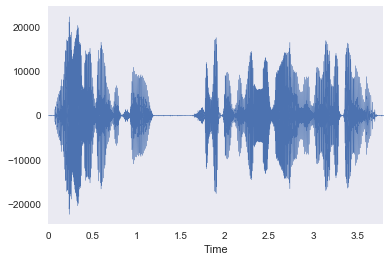

In [258]:
fs, x = wavfile_orig(SAMPLE_AUDIO_02)
plot_audio(x, fs)

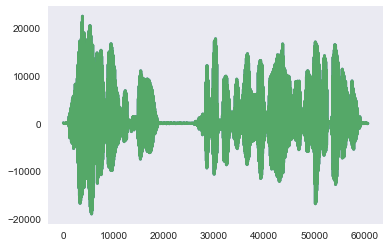

In [259]:
pitch = extract_pitch(x, fs)
plot_pitch(x, fs)

In [260]:
play_wav(x, fs)

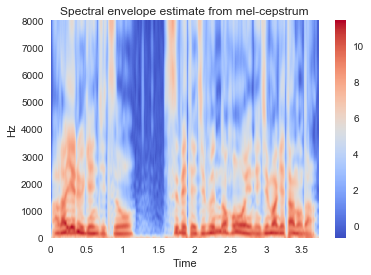

In [261]:
mcep = extract_mcep(x, fs, frame_length=CHUNK, hop_length=PERIOD, alpha=EXTRACT_ALPHA)

### 02. ピッチを調整し、再合成する

まずは、同じ音声の再合成。ノイズが入るのは仕方ないらしい...

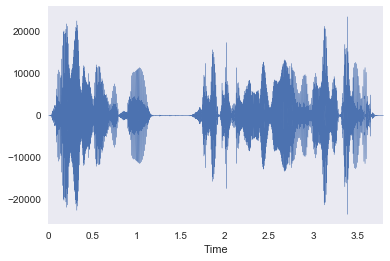

In [335]:
resynthesis(x, fs, pitch, mcep, hop_length=PERIOD, order=ORDER, alpha=EXTRACT_ALPHA, pitch_rate=1.0)

次に、ピッチを調整し、高い声にする。

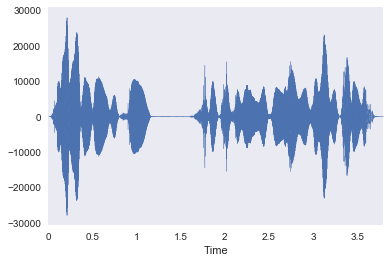

In [336]:
resynthesis(x, fs, pitch, mcep, hop_length=PERIOD, order=ORDER, alpha=EXTRACT_ALPHA, pitch_rate=0.5)

逆に、ピッチを調整し、低い声にする。

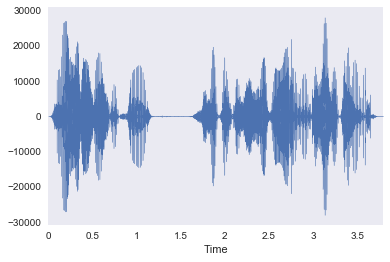

In [359]:
resynthesis(x, fs, pitch, mcep, hop_length=PERIOD, order=ORDER, alpha=EXTRACT_ALPHA, pitch_rate=1.5)

ピッチを0.0にすると、かすれた声になる

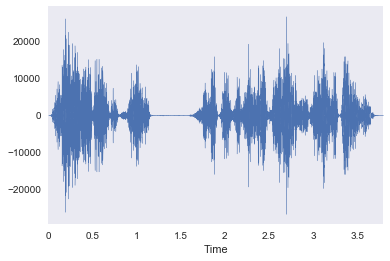

In [363]:
resynthesis(x, fs, pitch, mcep, hop_length=PERIOD, order=ORDER, alpha=EXTRACT_ALPHA, pitch_rate=0.0)

次は、声のスピードを変えてみる。

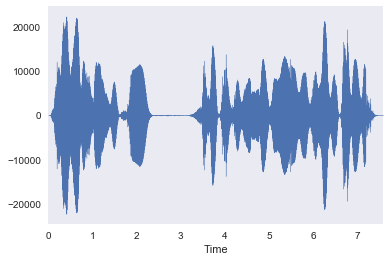

In [364]:
resynthesis(x, fs, pitch, mcep, hop_length=PERIOD, order=ORDER, alpha=EXTRACT_ALPHA, delay_rate=2)

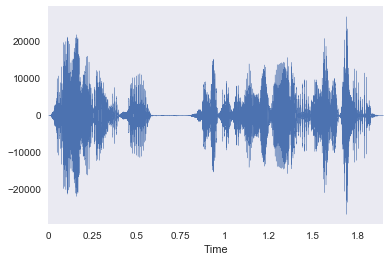

In [375]:
resynthesis(x, fs, pitch, mcep, hop_length=PERIOD, order=ORDER, alpha=EXTRACT_ALPHA, delay_rate=0.5)

### 03. 再合成を色々試してみる

子どもっぽい声

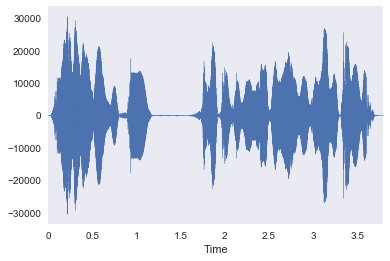

In [405]:
resynthesis(x, fs, pitch, mcep, hop_length=PERIOD, order=ORDER, alpha=0.1, pitch_rate=0.4)

犯罪者っぽい男女の声

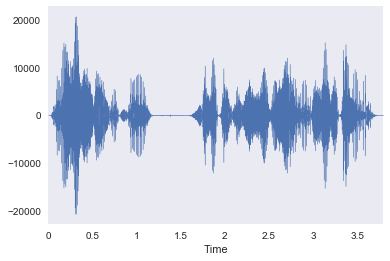

In [406]:
resynthesis(x, fs, pitch, mcep, hop_length=PERIOD, order=ORDER, alpha=0.6, pitch_rate=1.5)

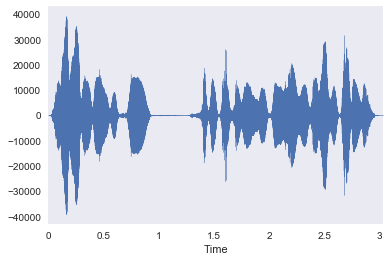

In [426]:
resynthesis(x, fs, pitch, mcep, hop_length=PERIOD, order=ORDER, alpha=0.0, pitch_rate=0.2, delay_rate=0.8)